     pcost       dcost       gap    pres   dres
 0: -3.3500e+00 -6.8308e+02  3e+03  1e+00  5e-16
 1: -5.4520e-02 -2.0543e+02  2e+02  7e-03  5e-16
 2: -4.4835e+00 -2.3807e+01  2e+01  6e-04  7e-16
 3: -5.4821e+00 -8.1961e+00  3e+00  7e-05  3e-16
 4: -5.6507e+00 -7.0826e+00  1e+00  1e-05  2e-16
 5: -5.7359e+00 -6.0676e+00  3e-01  3e-06  2e-16
 6: -5.7792e+00 -5.8518e+00  7e-02  1e-15  1e-16
 7: -5.7884e+00 -5.8122e+00  2e-02  6e-16  1e-16
 8: -5.7928e+00 -5.7993e+00  6e-03  3e-16  1e-16
 9: -5.7943e+00 -5.7957e+00  1e-03  1e-15  1e-16
10: -5.7947e+00 -5.7950e+00  3e-04  2e-15  1e-16
11: -5.7948e+00 -5.7948e+00  6e-05  6e-16  1e-16
12: -5.7948e+00 -5.7948e+00  3e-06  7e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.2819e+00 -7.1619e+02  3e+03  1e+00  5e-16
 1:  3.2028e+00 -2.4711e+02  3e+02  3e-15  6e-16
 2: -1.0837e+01 -3.0749e+01  2e+01  2e-15  8e-16
 3: -1.2487e+01 -1.8377e+01  6e+00  3e-15  3e-16
 4: -1.3174e+01 -1.5010e+01  2e+00  5e-16  3e-1

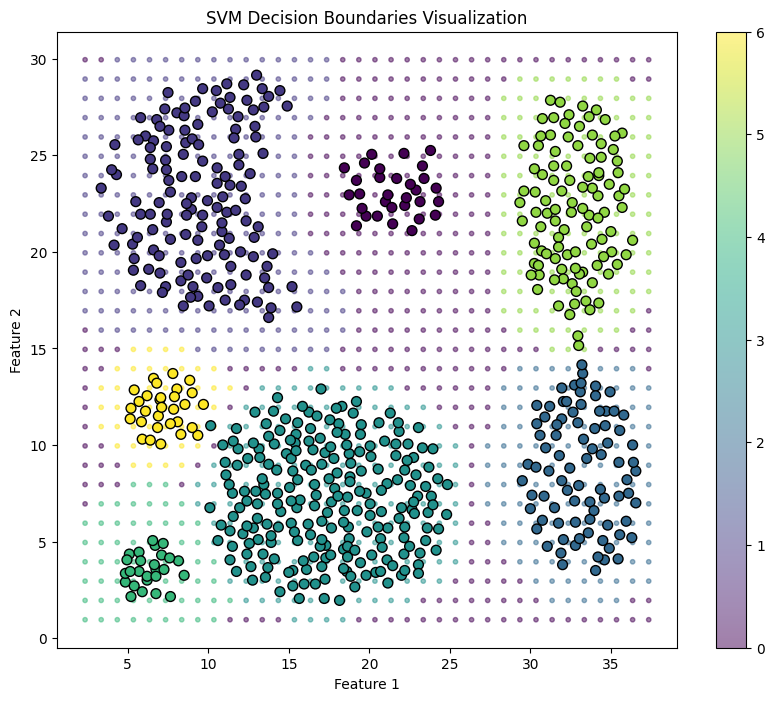

Test Accuracy: 0.9873417721518988 using Gamma: 10 and C: 1


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

def generate_X_test(df):
    step = 1
    min_F1 = df['Feature 1'].min() - 1
    max_F1 = df['Feature 1'].max() + 1
    min_F2 = df['Feature 2'].min() - 1
    max_F2 = df['Feature 2'].max() + 1

    x_values = np.arange(min_F1, max_F1, step)
    y_values = np.arange(min_F2, max_F2, step)
    x_mesh, y_mesh = np.meshgrid(x_values, y_values)
    x_test = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
    return x_test

df = pd.read_csv('/content/Aggregation.txt', delimiter='\t', skiprows=7)
df.rename(columns={'15.55': 'Feature 1', '28.65': 'Feature 2', '2': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_value = 10
C_value = 1

models = []
for cls in np.unique(y_train):
    y_train_cls = np.where(y_train == cls, 1, -1)
    K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma_value)
    BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
    alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C_value)

    sv_indices = alphas > 1e-5
    sv_alphas = alphas[sv_indices]
    sv_X = X_train_scaled[sv_indices]
    sv_y = y_train_cls[sv_indices]

    K_sv = K_train[sv_indices][:, sv_indices]
    min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
    max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
    bias = -0.5 * (min_class_positive + max_class_negative)

    models.append((sv_alphas, sv_X, sv_y, bias))

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.unique(y_train)[np.argmax(grid_predictions, axis=1)]

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()

decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma_value)
    decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy} using Gamma: {gamma_value} and C: {C_value}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Aggregation.txt', delimiter='\t', skiprows=7)
df.rename(columns={'15.55': 'Feature 1', '28.65': 'Feature 2', '2': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train RBF model
gamma_value = 1
C_value = 0.1
rbf_model = SVC(kernel='rbf', gamma=gamma_value, C=C_value)
rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = rbf_model.score(X_train_scaled, y_train)
test_accuracy = rbf_model.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


# flame

     pcost       dcost       gap    pres   dres
 0: -1.9132e+01 -2.5801e+02  2e+02  2e-15  5e-16
 1: -2.1793e+01 -4.4668e+01  2e+01  4e-15  4e-16
 2: -2.3210e+01 -2.6482e+01  3e+00  1e-15  3e-16
 3: -2.3570e+01 -2.4154e+01  6e-01  4e-16  3e-16
 4: -2.3670e+01 -2.3777e+01  1e-01  2e-16  3e-16
 5: -2.3689e+01 -2.3712e+01  2e-02  5e-16  3e-16
 6: -2.3694e+01 -2.3697e+01  4e-03  6e-16  3e-16
 7: -2.3694e+01 -2.3695e+01  2e-04  4e-16  4e-16
 8: -2.3695e+01 -2.3695e+01  5e-06  2e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9132e+01 -2.5801e+02  2e+02  2e-15  5e-16
 1: -2.1793e+01 -4.4668e+01  2e+01  4e-15  4e-16
 2: -2.3210e+01 -2.6482e+01  3e+00  1e-15  3e-16
 3: -2.3570e+01 -2.4154e+01  6e-01  4e-16  3e-16
 4: -2.3670e+01 -2.3777e+01  1e-01  2e-16  3e-16
 5: -2.3689e+01 -2.3712e+01  2e-02  5e-16  3e-16
 6: -2.3694e+01 -2.3697e+01  4e-03  6e-16  3e-16
 7: -2.3694e+01 -2.3695e+01  2e-04  4e-16  4e-16
 8: -2.3695e+01 -2.3695e+01  5e-06  2e-16  4e-1

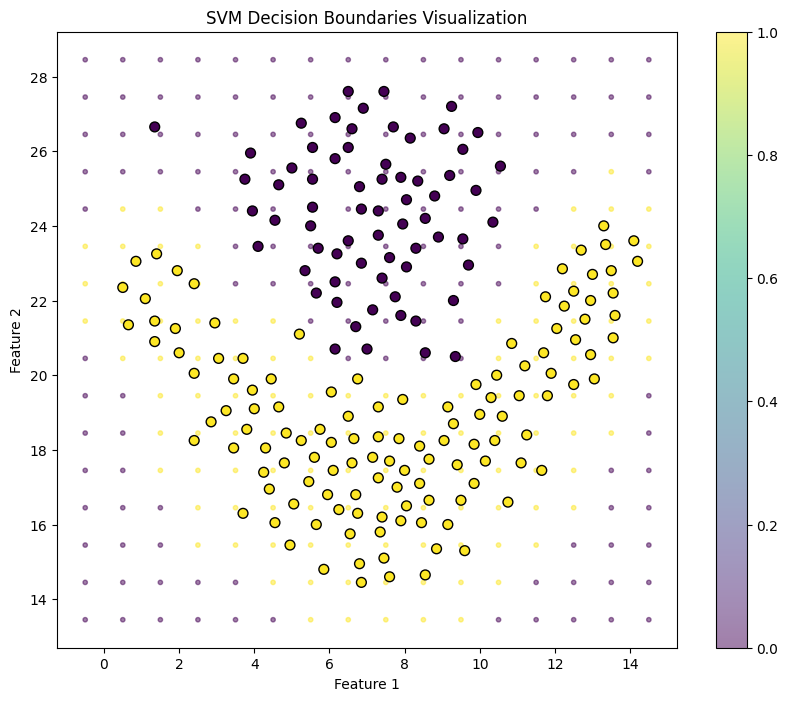

Test Accuracy: 0.9791666666666666 using Gamma: 10 and C: 1


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

def generate_X_test(df):
    step = 1
    min_F1 = df['Feature 1'].min() - 1
    max_F1 = df['Feature 1'].max() + 1
    min_F2 = df['Feature 2'].min() - 1
    max_F2 = df['Feature 2'].max() + 1

    x_values = np.arange(min_F1, max_F1, step)
    y_values = np.arange(min_F2, max_F2, step)
    x_mesh, y_mesh = np.meshgrid(x_values, y_values)
    x_test = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
    return x_test

df = pd.read_csv('/content/Flame.txt', delimiter='\t', skiprows=7)


df.rename(columns={'1.85': 'Feature 1', '27.8': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_value = 10
C_value = 1

models = []
for cls in np.unique(y_train):
    y_train_cls = np.where(y_train == cls, 1, -1)
    K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma_value)
    BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
    alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C_value)

    sv_indices = alphas > 1e-5
    sv_alphas = alphas[sv_indices]
    sv_X = X_train_scaled[sv_indices]
    sv_y = y_train_cls[sv_indices]

    K_sv = K_train[sv_indices][:, sv_indices]
    min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
    max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
    bias = -0.5 * (min_class_positive + max_class_negative)

    models.append((sv_alphas, sv_X, sv_y, bias))

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.unique(y_train)[np.argmax(grid_predictions, axis=1)]

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()

decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma_value)
    decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy} using Gamma: {gamma_value} and C: {C_value}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Flame.txt', delimiter='\t', skiprows=7)


df.rename(columns={'1.85': 'Feature 1', '27.8': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train RBF model
gamma_value = 0.5
C_value = 10
rbf_model = SVC(kernel='rbf', gamma=gamma_value, C=C_value)
rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = rbf_model.score(X_train_scaled, y_train)
test_accuracy = rbf_model.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


# jain

     pcost       dcost       gap    pres   dres
 0: -1.0763e+01 -3.7337e+02  1e+03  1e+00  4e-16
 1: -5.7778e+00 -1.5077e+02  1e+02  4e-15  5e-16
 2: -1.3674e+01 -3.2920e+01  2e+01  2e-15  6e-16
 3: -1.5285e+01 -1.9785e+01  4e+00  7e-16  3e-16
 4: -1.6030e+01 -1.7233e+01  1e+00  1e-15  2e-16
 5: -1.6261e+01 -1.6514e+01  3e-01  2e-15  2e-16
 6: -1.6328e+01 -1.6358e+01  3e-02  3e-15  3e-16
 7: -1.6333e+01 -1.6352e+01  2e-02  2e-15  2e-16
 8: -1.6339e+01 -1.6340e+01  1e-03  4e-15  3e-16
 9: -1.6340e+01 -1.6340e+01  2e-05  2e-16  3e-16
10: -1.6340e+01 -1.6340e+01  3e-07  1e-15  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0763e+01 -3.7337e+02  1e+03  1e+00  4e-16
 1: -5.7778e+00 -1.5077e+02  1e+02  4e-15  5e-16
 2: -1.3674e+01 -3.2920e+01  2e+01  2e-15  6e-16
 3: -1.5285e+01 -1.9785e+01  4e+00  7e-16  3e-16
 4: -1.6030e+01 -1.7233e+01  1e+00  1e-15  2e-16
 5: -1.6261e+01 -1.6514e+01  3e-01  2e-15  2e-16
 6: -1.6328e+01 -1.6358e+01  3e-02  3e-15  3e-1

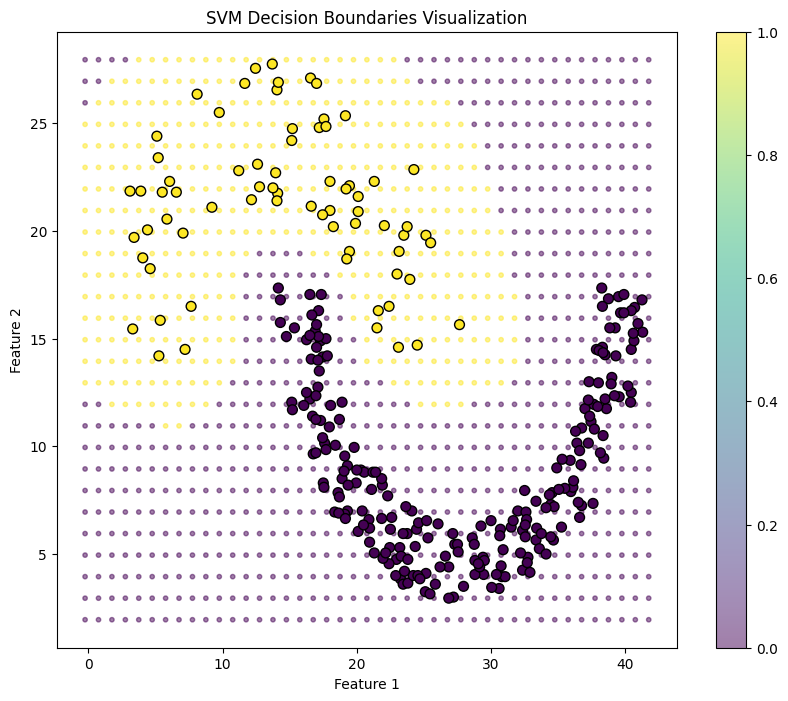

Test Accuracy: 1.0 using Gamma: 10 and C: 1


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

def generate_X_test(df):
    step = 1
    min_F1 = df['Feature 1'].min() - 1
    max_F1 = df['Feature 1'].max() + 1
    min_F2 = df['Feature 2'].min() - 1
    max_F2 = df['Feature 2'].max() + 1

    x_values = np.arange(min_F1, max_F1, step)
    y_values = np.arange(min_F2, max_F2, step)
    x_mesh, y_mesh = np.meshgrid(x_values, y_values)
    x_test = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
    return x_test

df = pd.read_csv('/content/Jain.txt', delimiter='\t', skiprows=7)
df.rename(columns={'0.85': 'Feature 1', '17.45': 'Feature 2', '2': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_value = 10
C_value = 1

models = []
for cls in np.unique(y_train):
    y_train_cls = np.where(y_train == cls, 1, -1)
    K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma_value)
    BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
    alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C_value)

    sv_indices = alphas > 1e-5
    sv_alphas = alphas[sv_indices]
    sv_X = X_train_scaled[sv_indices]
    sv_y = y_train_cls[sv_indices]

    K_sv = K_train[sv_indices][:, sv_indices]
    min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
    max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
    bias = -0.5 * (min_class_positive + max_class_negative)

    models.append((sv_alphas, sv_X, sv_y, bias))

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.unique(y_train)[np.argmax(grid_predictions, axis=1)]

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()

decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma_value)
    decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy} using Gamma: {gamma_value} and C: {C_value}")

# Check for Built-in model

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Jain.txt', delimiter='\t', skiprows=7)
df.rename(columns={'0.85': 'Feature 1', '17.45': 'Feature 2', '2': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

# Create and train grid search
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create and train RBF model with best parameters
best_rbf_model = SVC(kernel='rbf', **best_params)
best_rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = best_rbf_model.score(X_train_scaled, y_train)
test_accuracy = best_rbf_model.score(X_test_scaled, y_test)

print("Best Parameters:", best_params)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'C': 1, 'gamma': 1}
Train Accuracy: 1.0
Test Accuracy: 1.0


# compound

     pcost       dcost       gap    pres   dres
 0: -2.5796e+01 -4.6291e+02  2e+03  2e+00  5e-16
 1: -2.3158e+01 -2.0394e+02  2e+02  4e-15  5e-16
 2: -2.5279e+01 -5.8851e+01  3e+01  3e-15  5e-16
 3: -2.7345e+01 -3.2875e+01  6e+00  6e-16  2e-16
 4: -2.7922e+01 -2.9465e+01  2e+00  7e-16  2e-16
 5: -2.8176e+01 -2.8518e+01  3e-01  3e-16  2e-16
 6: -2.8244e+01 -2.8334e+01  9e-02  1e-15  2e-16
 7: -2.8264e+01 -2.8287e+01  2e-02  2e-16  2e-16
 8: -2.8270e+01 -2.8273e+01  3e-03  2e-16  2e-16
 9: -2.8271e+01 -2.8271e+01  7e-05  3e-16  2e-16
10: -2.8271e+01 -2.8271e+01  1e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.0474e+00 -3.7152e+02  1e+03  1e+00  5e-16
 1: -3.6850e+00 -1.3484e+02  1e+02  3e-16  5e-16
 2: -1.1021e+01 -3.5273e+01  2e+01  8e-16  6e-16
 3: -1.3584e+01 -1.9276e+01  6e+00  1e-15  3e-16
 4: -1.4315e+01 -1.5672e+01  1e+00  2e-15  2e-16
 5: -1.4486e+01 -1.4721e+01  2e-01  2e-15  2e-16
 6: -1.4521e+01 -1.4571e+01  5e-02  1e-15  2e-1

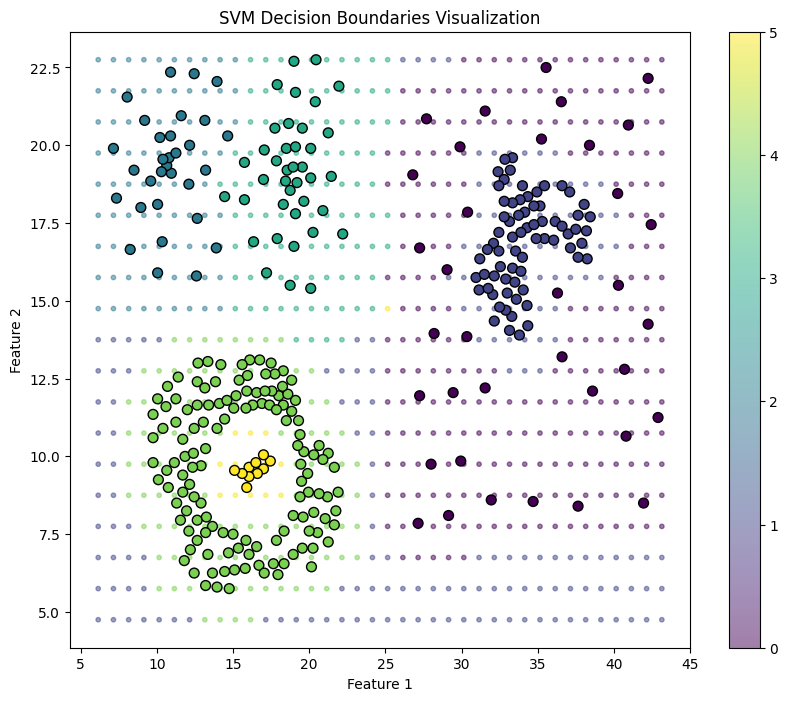

Test Accuracy: 1.0 using Gamma: 10 and C: 1


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

def generate_X_test(df):
    step = 1
    min_F1 = df['Feature 1'].min() - 1
    max_F1 = df['Feature 1'].max() + 1
    min_F2 = df['Feature 2'].min() - 1
    max_F2 = df['Feature 2'].max() + 1

    x_values = np.arange(min_F1, max_F1, step)
    y_values = np.arange(min_F2, max_F2, step)
    x_mesh, y_mesh = np.meshgrid(x_values, y_values)
    x_test = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
    return x_test

df = pd.read_csv('/content/Compound.txt', delimiter='\t', skiprows=7)
df.rename(columns={'26.75': 'Feature 1', '22.15': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_value = 10
C_value = 1

models = []
for cls in np.unique(y_train):
    y_train_cls = np.where(y_train == cls, 1, -1)
    K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma_value)
    BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
    alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C_value)

    sv_indices = alphas > 1e-5
    sv_alphas = alphas[sv_indices]
    sv_X = X_train_scaled[sv_indices]
    sv_y = y_train_cls[sv_indices]

    K_sv = K_train[sv_indices][:, sv_indices]
    min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
    max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
    bias = -0.5 * (min_class_positive + max_class_negative)

    models.append((sv_alphas, sv_X, sv_y, bias))

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.unique(y_train)[np.argmax(grid_predictions, axis=1)]

# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()

decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma_value)
    decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy} using Gamma: {gamma_value} and C: {C_value}")

# Check for Built-in model

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Compound.txt', delimiter='\t', skiprows=7)
df.rename(columns={'26.75': 'Feature 1', '22.15': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train RBF model
gamma_value = 10
C_value = 1
rbf_model = SVC(kernel='rbf', gamma=gamma_value, C=C_value)
rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = rbf_model.score(X_train_scaled, y_train)
test_accuracy = rbf_model.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 1.0
Test Accuracy: 1.0


# Pathbased

     pcost       dcost       gap    pres   dres
 0: -4.9300e+01 -4.2622e+02  2e+03  2e+00  3e-15
 1: -3.6552e+01 -2.2988e+02  2e+02  9e-16  3e-15
 2: -4.7154e+01 -8.5156e+01  4e+01  3e-16  2e-15
 3: -5.5033e+01 -6.8155e+01  1e+01  3e-15  2e-15
 4: -5.7620e+01 -6.3813e+01  6e+00  1e-15  2e-15
 5: -5.8857e+01 -6.1471e+01  3e+00  2e-16  2e-15
 6: -5.9566e+01 -6.0302e+01  7e-01  9e-16  3e-15
 7: -5.9773e+01 -6.0026e+01  3e-01  6e-16  2e-15
 8: -5.9868e+01 -5.9906e+01  4e-02  3e-16  3e-15
 9: -5.9886e+01 -5.9886e+01  8e-04  1e-15  3e-15
10: -5.9886e+01 -5.9886e+01  9e-06  3e-15  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.9209e+01 -4.6761e+02  2e+03  2e+00  3e-15
 1: -5.6350e+01 -2.7657e+02  3e+02  1e-01  2e-15
 2: -5.6907e+01 -9.3099e+01  4e+01  2e-02  2e-15
 3: -6.3058e+01 -7.6767e+01  1e+01  6e-03  2e-15
 4: -6.5754e+01 -7.2267e+01  7e+00  2e-03  2e-15
 5: -6.7324e+01 -6.9634e+01  2e+00  7e-04  3e-15
 6: -6.8151e+01 -6.8452e+01  3e-01  3e-05  3e-1

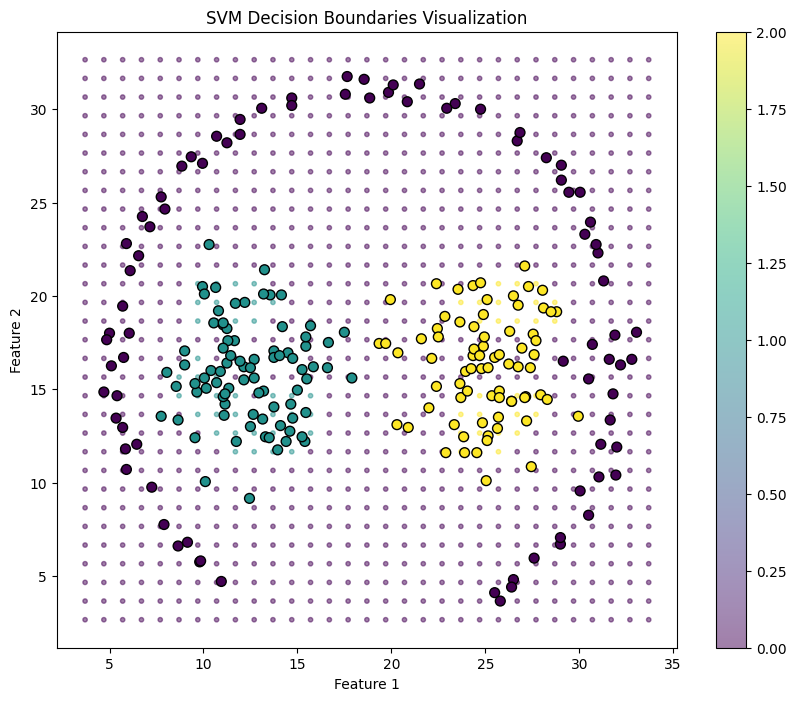

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

# Load data
df = pd.read_csv('/content/Pathbased.txt', delimiter='\t', skiprows=7)
# Load the data
df.rename(columns={'11.25': 'Feature 1', '5.05': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_values = [0.1]
C_values = [1]
best_accuracy = 0
best_gamma = 0.1
best_C = 1.0

for gamma in gamma_values:
    for C in C_values:
        models = []
        for cls in np.unique(y_train):
            y_train_cls = np.where(y_train == cls, 1, -1)
            K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma)
            BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
            alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C)

            sv_indices = alphas > 1e-5
            sv_alphas = alphas[sv_indices]
            sv_X = X_train_scaled[sv_indices]
            sv_y = y_train_cls[sv_indices]

            K_sv = K_train[sv_indices][:, sv_indices]
            min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
            max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
            bias = -0.5 * (min_class_positive + max_class_negative)

            models.append((sv_alphas, sv_X, sv_y, bias))

        # Calculate decision scores and predict
        decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
        for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
            K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma)
            decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

        predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
        accuracy = accuracy_score(y_test, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_gamma = gamma
            best_C = C

print(f"Best Test Accuracy: {best_accuracy} using Gamma: {best_gamma} and C: {best_C}")
# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()


# Check for Built-in model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Pathbased.txt', delimiter='\t', skiprows=7)
df.rename(columns={'11.25': 'Feature 1', '5.05': 'Feature 2', '1': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train RBF model
gamma_value = 0.1
C_value = 1
rbf_model = SVC(kernel='rbf', gamma=gamma_value, C=C_value)
rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = rbf_model.score(X_train_scaled, y_train)
test_accuracy = rbf_model.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.9790794979079498
Test Accuracy: 0.9666666666666667


# spiral

     pcost       dcost       gap    pres   dres
 0: -1.7513e+01 -3.3467e+02  3e+02  7e-15  5e-16
 1: -2.0746e+01 -4.0525e+01  2e+01  3e-15  4e-16
 2: -2.1509e+01 -2.5676e+01  4e+00  1e-15  2e-16
 3: -2.1674e+01 -2.2560e+01  9e-01  3e-16  2e-16
 4: -2.1734e+01 -2.1962e+01  2e-01  1e-16  2e-16
 5: -2.1763e+01 -2.1829e+01  7e-02  1e-15  2e-16
 6: -2.1773e+01 -2.1787e+01  1e-02  6e-16  2e-16
 7: -2.1775e+01 -2.1779e+01  3e-03  2e-16  2e-16
 8: -2.1776e+01 -2.1776e+01  4e-04  6e-16  2e-16
 9: -2.1776e+01 -2.1776e+01  4e-05  2e-16  2e-16
10: -2.1776e+01 -2.1776e+01  1e-06  2e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7213e+01 -3.3500e+02  3e+02  8e-15  5e-16
 1: -2.0600e+01 -3.9924e+01  2e+01  3e-15  4e-16
 2: -2.1375e+01 -2.4685e+01  3e+00  9e-16  2e-16
 3: -2.1517e+01 -2.2035e+01  5e-01  2e-15  2e-16
 4: -2.1573e+01 -2.1701e+01  1e-01  3e-15  2e-16
 5: -2.1590e+01 -2.1618e+01  3e-02  2e-16  2e-16
 6: -2.1595e+01 -2.1601e+01  5e-03  3e-16  2e-1

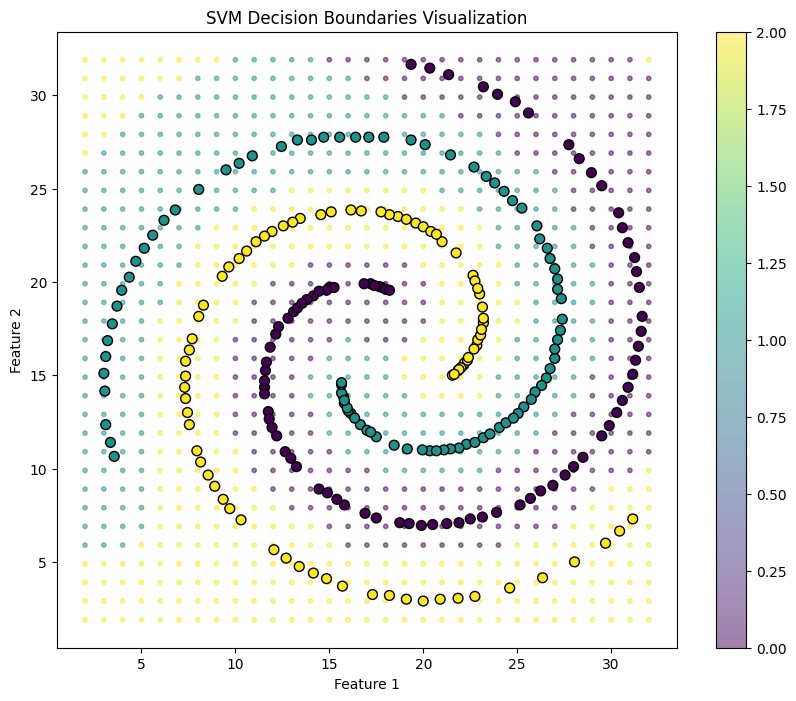

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma=0.5):
    """ Compute the RBF (Gaussian) kernel between X1 and X2. """
    pairwise_sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * pairwise_sq_dists)

def QuadProg(BigMatrix, Y, n, C=1.0):
    """ Solve the quadratic programming problem for SVM using cvxopt library. """
    P = cvxopt.matrix(BigMatrix, tc='d')
    q = cvxopt.matrix([-1.0] * n)
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix([0.0] * n + [C] * n)
    A_eq = cvxopt.matrix(Y.reshape(1, -1).astype(float), tc='d')
    b_eq = cvxopt.matrix(0.0, (1, 1))
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)
    return np.ravel(sol['x'])

def generate_X_test(df):
    step = 1
    min_F1 = df['Feature 1'].min() - 1
    max_F1 = df['Feature 1'].max() + 1
    min_F2 = df['Feature 2'].min() - 1
    max_F2 = df['Feature 2'].max() + 1

    x_values = np.arange(min_F1, max_F1, step)
    y_values = np.arange(min_F2, max_F2, step)
    x_mesh, y_mesh = np.meshgrid(x_values, y_values)
    x_test = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
    return x_test

df = pd.read_csv('/content/Spiral.txt', delimiter='\t', skiprows=7)
# Load the data
df.rename(columns={'31.95': 'Feature 1', '7.95': 'Feature 2', '3': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimal parameter search
gamma_value = 10
C_value = 1

models = []
for cls in np.unique(y_train):
    y_train_cls = np.where(y_train == cls, 1, -1)
    K_train = rbf_kernel(X_train_scaled, X_train_scaled, gamma=gamma_value)
    BigMatrix = K_train * np.outer(y_train_cls, y_train_cls)
    alphas = QuadProg(BigMatrix, Y=y_train_cls, n=len(X_train), C=C_value)

    sv_indices = alphas > 1e-5
    sv_alphas = alphas[sv_indices]
    sv_X = X_train_scaled[sv_indices]
    sv_y = y_train_cls[sv_indices]

    K_sv = K_train[sv_indices][:, sv_indices]
    min_class_positive = np.min(np.dot(sv_alphas[sv_y == 1], K_sv[sv_y == 1]))
    max_class_negative = np.max(np.dot(sv_alphas[sv_y == -1], K_sv[sv_y == -1])) if (sv_y == -1).any() else 0
    bias = -0.5 * (min_class_positive + max_class_negative)

    models.append((sv_alphas, sv_X, sv_y, bias))

# Calculate decision scores and predict
decision_scores = np.zeros((X_test_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_test = rbf_kernel(X_test_scaled, sv_X, gamma=gamma_value)
    decision_scores[:, i] = np.dot(K_test, sv_alphas * sv_y) + bias

predictions = np.unique(y_train)[np.argmax(decision_scores, axis=1)]
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy} using Gamma: {gamma_value} and C: {C_value}")
# Generate grid for visualization
X_grid_test = generate_X_test(df)
X_grid_scaled = scaler.transform(X_grid_test)

# Predict using grid
grid_predictions = np.zeros((X_grid_scaled.shape[0], len(models)))
for i, (sv_alphas, sv_X, sv_y, bias) in enumerate(models):
    K_grid = rbf_kernel(X_grid_scaled, sv_X, gamma=gamma_value)
    grid_predictions[:, i] = np.dot(K_grid, sv_alphas * sv_y) + bias

grid_labels = np.argmax(grid_predictions, axis=1)

# Plotting the decision boundaries with distinct colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_grid_test[:, 0], X_grid_test[:, 1], c=grid_labels, alpha=0.5, s=10, cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', s=50, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries Visualization')
plt.show()


# Check for Built-in model

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('/content/Spiral.txt', delimiter='\t', skiprows=7)
# Load the data
df.rename(columns={'31.95': 'Feature 1', '7.95': 'Feature 2', '3': 'Class'}, inplace=True)

X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train RBF model
gamma_value = 10
C_value = 1
rbf_model = SVC(kernel='rbf', gamma=gamma_value, C=C_value)
rbf_model.fit(X_train_scaled, y_train)

# Evaluate model
train_accuracy = rbf_model.score(X_train_scaled, y_train)
test_accuracy = rbf_model.score(X_test_scaled, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 1.0
Test Accuracy: 1.0
